In [1]:
from mp_api.client import MPRester
from pymatgen.core.periodic_table import Element
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from emmet.core.summary import HasProps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import csv
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import sklearn.linear_model

In [ ]:
API_KEY = ""

# Initialize storage for each structure type
bcc, fcc, sc = [], [], []
bcc_a, fcc_a, sc_a = [], [], []
bcc_k, fcc_k, sc_k = [], [], []
bcc_symbol, fcc_symbol, sc_symbol = [], [], []
bcc_elements, fcc_elements, sc_elements = [], [], []

# Mapping space group numbers to structure types
valid_sg = {229: "bcc", 225: "fcc", 221: "sc"}

with MPRester(API_KEY, mute_progress_bars=True) as mpr:
    metallic_elements = [el.symbol for el in Element if el.is_metal and el.number <= 83 and el.symbol not in ["Hg", "Fr", "Ra"]]

    for el in metallic_elements:
        try:
            # Query all elemental, nonmagnetic structures
            entries = mpr.materials.summary.search(
                formula=el,
                is_metal=True,
                total_magnetization=(0, 0.01),
                fields=["material_id", "structure", "formula_pretty", "bulk_modulus", "symmetry", "elements", "energy_above_hull"]
            )

            # Filter for valid cubic space groups
            cubic_entries = [e for e in entries if e.symmetry.number in valid_sg]

            if not cubic_entries:
                continue  # skip if no BCC/FCC/SC found

            # Pick the lowest-energy cubic structure
            best = min(cubic_entries, key=lambda x: x.energy_above_hull)

            spa = SpacegroupAnalyzer(best.structure)
            conventional_structure = spa.get_conventional_standard_structure()
            a = conventional_structure.lattice.a
            k = best.bulk_modulus["vrh"] if best.bulk_modulus else None
            structure_type = valid_sg[best.symmetry.number]

            # Store in appropriate list
            if structure_type == "bcc":
                bcc.append(best.material_id)
                bcc_a.append(a)
                bcc_k.append(k)
                bcc_symbol.append(best.formula_pretty)
                bcc_elements.append(best.elements)
            elif structure_type == "fcc":
                fcc.append(best.material_id)
                fcc_a.append(a)
                fcc_k.append(k)
                fcc_symbol.append(best.formula_pretty)
                fcc_elements.append(best.elements)
            elif structure_type == "sc":
                sc.append(best.material_id)
                sc_a.append(a)
                sc_k.append(k)
                sc_symbol.append(best.formula_pretty)
                sc_elements.append(best.elements)

        except Exception as e:
            print(f"Error for {el}: {e}")

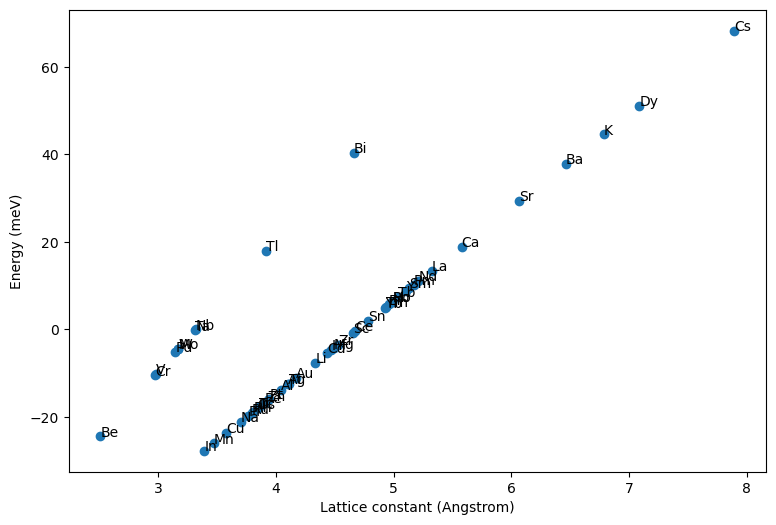

In [3]:
def calculate_mismatch(a1_Angstrom, structure):
    if structure=='fcc':
        a = a1_Angstrom / np.sqrt(2)
    else:
        a = a1_Angstrom
    a_nb = 3.3176323792962297

    return(a - a_nb) / a_nb * 100


symbols_label = []
mismatch = []
mp_ids = []
lattice_constants = []
elements = []

for i in range(len(bcc)):
    mismatch.append(calculate_mismatch(bcc_a[i], structure='bcc'))
    symbols_label.append(bcc_symbol[i])
    mp_ids.append(bcc[i])
    lattice_constants.append(bcc_a[i])
    elements.append(bcc_elements[i])

for i in range(len(fcc)):
    mismatch.append(calculate_mismatch(fcc_a[i], structure='fcc'))
    symbols_label.append(fcc_symbol[i])
    mp_ids.append(fcc[i])
    lattice_constants.append(fcc_a[i])
    elements.append(fcc_elements[i])

for i in range(len(sc)):
    mismatch.append(calculate_mismatch(sc_a[i], structure='sc'))
    symbols_label.append(sc_symbol[i])
    mp_ids.append(sc[i])
    lattice_constants.append(sc_a[i])
    elements.append(sc_elements[i])

#create a dataframe
df = pd.DataFrame(list(zip(symbols_label, mismatch, mp_ids, lattice_constants, elements)), columns =['Symbol', 'Mismatch', 'mp_id', 'lattice_constant', 'elements'])
#sort by energy
df = df.sort_values(by=['Mismatch'])

#remove negative values
# df = df[df['Energy'] >= 0]

df = df.groupby('Symbol').first().reset_index()
df = df.sort_values(by=['Mismatch'])

#convert energy to meV
# df['Energy'] = df['Energy']*6.242e+15

# %matplotlib widget

last_ind = 500

#plot lattice constant vs energy, add label with symbol
plt.figure(figsize=(9, 6))
plt.scatter(df['lattice_constant'][:last_ind], df['Mismatch'][:last_ind], )
for i, txt in enumerate(df['Symbol'][:last_ind]):
    plt.annotate(txt, (df['lattice_constant'].iloc[i], df['Mismatch'].iloc[i]))
plt.xlabel('Lattice constant (Angstrom)')
plt.ylabel('Energy (meV)')
# plt.ylim(0,0.001)
#add vertical line at 3.32
# plt.axvline(x=3.32, color='r', linestyle='--')
# plt.axvline(x=3.32*np.sqrt(2), color='r', linestyle='--')

#add shaded region with green below 0.001 meV
# plt.axhspan(0, 0.001, color='green', alpha=0.1)
plt.show()
# df.head(50)


In [4]:
df.head(50)

,Symbol,Mismatch,mp_id,lattice_constant,elements
16,In,-27.759386,mp-85,3.389415,[In]
22,Mn,-26.047120,mp-8634,3.469751,[Mn]
4,Be,-24.456913,mp-20,2.506242,[Be]
11,Cu,-23.752086,mp-30,3.577431,[Cu]
24,Na,-21.176134,mp-974558,3.698290,[Na]
31,Pr,-19.744207,mp-97,3.765474,[Pr]
35,Ru,-19.192093,mp-8639,3.791378,[Ru]
34,Rh,-18.881045,mp-74,3.805972,[Rh]
27,Os,-18.068771,mp-8643,3.844083,[Os]
17,Ir,-17.858905,mp-101,3.853929,[Ir]


In [5]:
#cut df to only include the first 100 rows with the lowest energy
# df = df.head(100)
# df = df[(df["Mismatch"] >= -10) & (df["Mismatch"] <= 10)].sort_values(by="Mismatch")


elements_list = df['elements'].tolist()
symbols_list = df['Symbol'].tolist()

for i,elem in tqdm(enumerate(elements_list)):
    chemsys = symbols_list[i]
    chemsys += '-O'
    with MPRester('qy9RSVA3e6CHmVxpRp5ZOyimycBYT4Jc', mute_progress_bars=True) as mpr:
        docs = mpr.materials.summary.search(chemsys=chemsys, fields=["formation_energy_per_atom","formula_pretty", "material_id"])
        formation_e = 100
        for doc in docs:
            if doc.formation_energy_per_atom < formation_e:
                formation_e = doc.formation_energy_per_atom
                df.loc[df['Symbol']==symbols_list[i], 'oxide_formation_energy'] = formation_e
                df.loc[df['Symbol']==symbols_list[i], 'oxide_mp_id'] = doc.material_id
                df.loc[df['Symbol']==symbols_list[i], 'oxide_formula'] = doc.formula_pretty

0it [00:00, ?it/s]

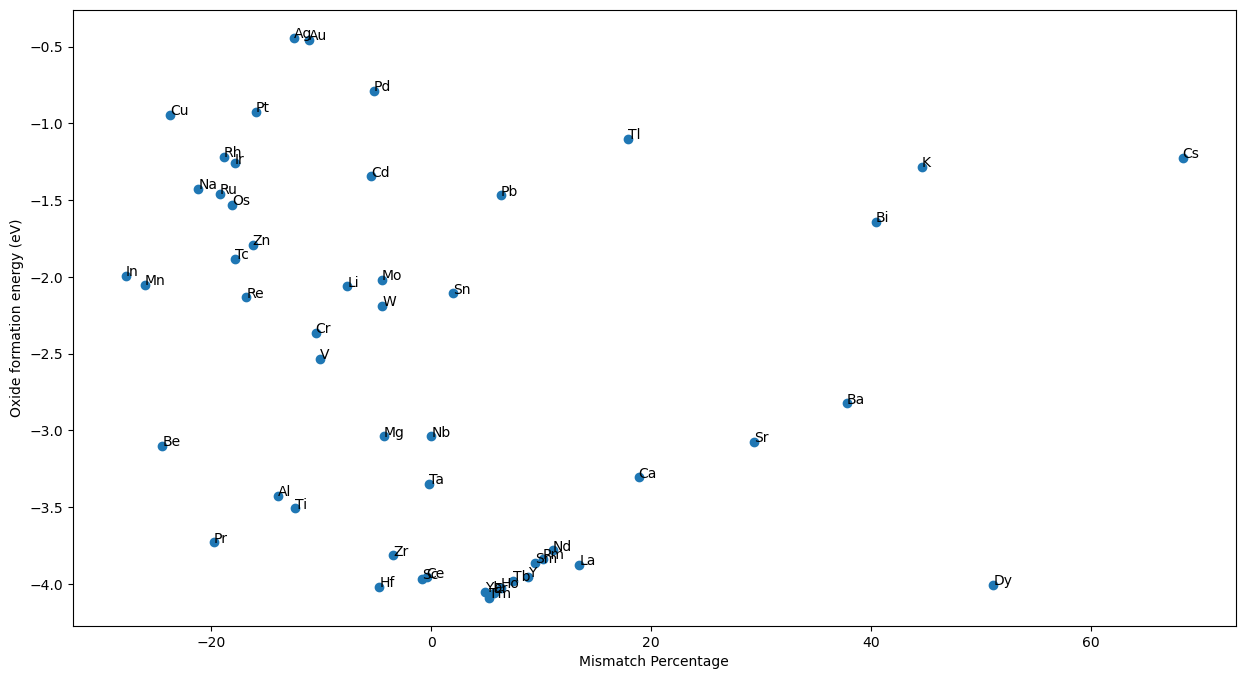

,Symbol,Mismatch,mp_id,lattice_constant,elements,oxide_formation_energy,oxide_mp_id,oxide_formula
16,In,-27.759386,mp-85,3.389415,[In],-1.994067,mp-22598,In2O3
22,Mn,-26.047120,mp-8634,3.469751,[Mn],-2.050409,mp-18759,Mn3O4
4,Be,-24.456913,mp-20,2.506242,[Be],-3.102856,mp-2542,BeO
11,Cu,-23.752086,mp-30,3.577431,[Cu],-0.942795,mp-1692,CuO
24,Na,-21.176134,mp-974558,3.698290,[Na],-1.425739,mp-2352,Na2O
31,Pr,-19.744207,mp-97,3.765474,[Pr],-3.729270,mp-16705,Pr2O3
35,Ru,-19.192093,mp-8639,3.791378,[Ru],-1.457662,mp-825,RuO2
34,Rh,-18.881045,mp-74,3.805972,[Rh],-1.218955,mp-725,RhO2
27,Os,-18.068771,mp-8643,3.844083,[Os],-1.529193,mp-1524458,OsO4
17,Ir,-17.858905,mp-101,3.853929,[Ir],-1.260893,mp-2723,IrO2


In [6]:

#plot energy vs oxide formation energy
plt.figure(figsize=(15, 8))
plt.scatter(df['Mismatch'], df['oxide_formation_energy'])

for i, txt in enumerate(df['Symbol']):
    plt.annotate(txt, (df['Mismatch'].iloc[i], df['oxide_formation_energy'].iloc[i]))
plt.xlabel('Mismatch Percentage')
plt.ylabel('Oxide formation energy (eV)')
plt.show()

df.head(50)

In [7]:

# Open the CSV and read all rows as lists of strings
with open("DFT_Data - Input.csv", 'r') as x:
    data = list(csv.reader(x, delimiter=","))

# Deletes title row
data = data[1:]

# Remove empty string entries from each row (e.g., stray commas)
data = [[i for i in item if i != ''] for item in data]

# Drop any now-empty rows
data = [item for item in data if item != []]

# --- Extract categorical columns ---

# First column = metal name (string label)
metals = np.array([x[0] for x in data])

# Fifth column (index 4) = structure label ('fcc', 'hcp', 'bcc', etc.)
structure = np.array([x[4] for x in data])

# Number of entries
l = len(metals)
print(l)

# Map structure labels into a simple numeric encoding:
# start as +1 for all, then set close-packed structures to -1.
# (Net effect: 'bcc' stays +1 while 'fcc'/'hcp' become -1.)
structuren = np.ones(l)
structuren[structure == 'fcc'] = -1
structuren[structure == 'hcp'] = -1

# Human-readable names for the numeric columns you’ll slice out below
names = [
    'Interstitial Barrier Energies',
    'Barrier Vacancy Energies',
    'Metal Interstitial Energies',
    'Oxide Vacancy Energies'
]

# Quick debug prints to verify parsing
print(metals)
print(structure)
print(structuren)

# --- Extract numeric feature columns ---

# Keep only columns from index 5 onward; earlier columns are metadata/labels
data = [x[5:] for x in data]

# Inspect one row to confirm width
print(data)
print(len(data[0]))

# Convert strings to floats; turn literal 'NaN' strings into np.nan
data = np.array(
    [[np.nan if x == 'NaN' else x for x in item] for item in data],
    dtype=float
)

print(data)

# --- Color utilities for plotting ---

# A soft color intensity used below (0.75)
c = 0.75

# Define a simple green→yellow→red colormap (useful for heat/score visuals)
edgecolors = [(0, c, 0), (c, c, 0), (c, 0, 0)]  # green, yellow, red
custom_cmap = LinearSegmentedColormap.from_list("green_yellow_red", edgecolors)

# Assign per-entry colors for a binary/ternary “experimental” label in data[:,0]
# Default to black
colors_exp = np.full(l, mpl.colors.to_hex((0, 0, 0)))

# If first numeric column == 0 → green; == 1 → red; NaN → keep black
colors_exp[data[:, 0] == 0] = mpl.colors.to_hex((0, c, 0))
colors_exp[data[:, 0] == np.nan] = mpl.colors.to_hex((0, 0, 0))
colors_exp[data[:, 0] == 1] = mpl.colors.to_hex((c, 0, 0))

# Transparency for scatter/patches
alpha = 0.075

# Font sizes for titles/labels/legends
fs = 24   # big font (titles/axes)
fs2 = 16  # smaller font (ticks/legends)

29
['Nb' 'Ta' 'Mo' 'W' 'Al' 'Au' 'Pd' 'Pt' 'Zr' 'Ti-W' 'Ti-W3' 'Be' 'Hf' 'V'
 'Cr' 'Ir' 'Co' 'Rh' 'Sc' 'Y' 'Re' 'Tc' 'Bi' 'Ru' 'Cu' 'Mn' 'Ti' 'Os' 'Zn']
['bcc' 'bcc' 'bcc' 'bcc' 'fcc' 'fcc' 'fcc' 'fcc' 'hcp' 'sc*' 'bcc*' 'hcp'
 'hcp' 'bcc' 'bcc' 'fcc' 'hcp' 'fcc' 'hcp' 'hcp' 'hcp' 'hcp' 'trigonal'
 'hcp' 'fcc' 'bcc' 'hcp' 'hcp' 'hcp']
[ 1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1.]
[['NaN', '2.00', '5.00', '0.64', '1.30', '-3.50', '5.89', '-3.02', '2.39', '-2.39', '0.00'], ['0.00', '2.00', '5.00', '0.68', '1.38', '-3.51', '5.58', '-3.08', '2.07', '-2.38', '0.01'], ['0.00', '1.00', '3.00', '0.82', '1.22', '-0.33', '3.86', '-1.92', '3.53', '-5.56', '-3.17'], ['0.00', '1.00', '3.00', '0.66', '1.13', '0.61', '2.54', '-2.19', '3.15', '-6.50', '-4.11'], ['0.00', '2.00', '3.00', '0.90', 'NaN', '-3.92', '7.28', '-3.42', '3.36', '-1.97', '0.42'], ['1.00', '1.00', '2.00', '0.51', '0.67', '1.69', '0.38', '-0.31', '2.07', '-7.5

In [8]:
# Metal Intersitital Energy
mi = data[:,5]
# Oxide Vacancy Energy
of = data[:,6]
# Formation Energy per oxygen
fe = data[:,7] * (data[:,1] + data[:,2]) / data[:,2]

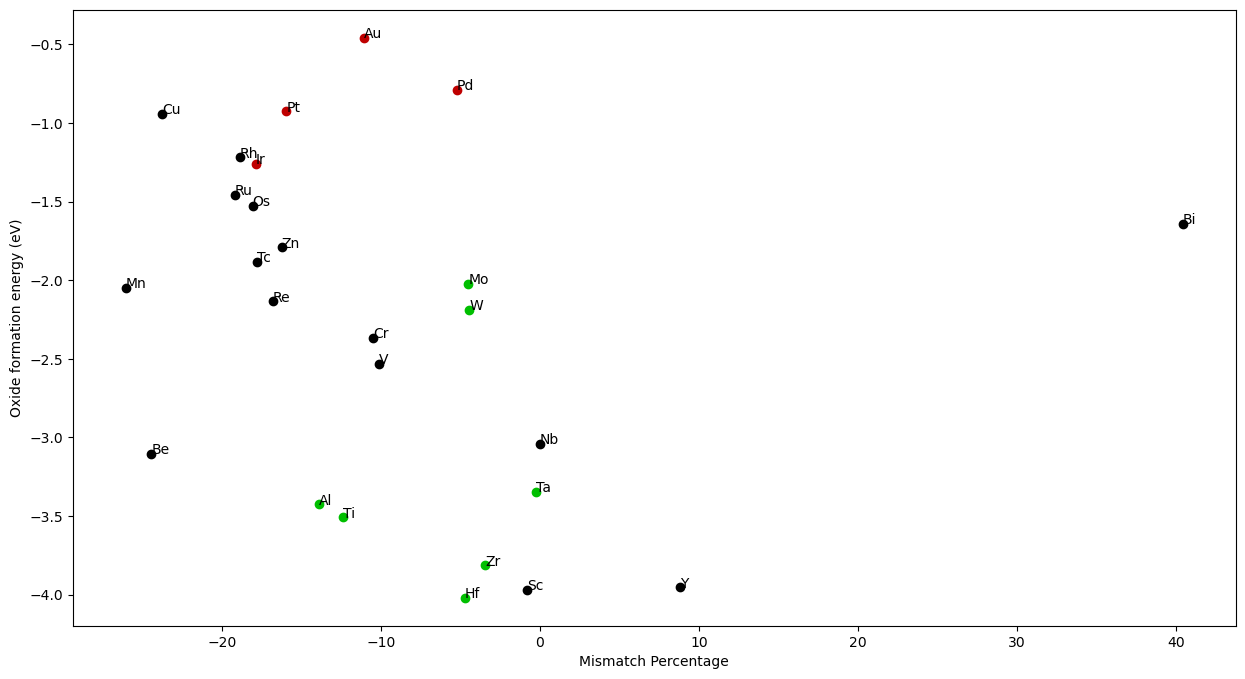

In [9]:
plt.figure(figsize=(15, 8))

# for i, met in enumerate(metals):
#     if data[i,0] == 0:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i])
#     elif data[i,0] == 1:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i])

for i, met in enumerate(metals):
    plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i])

for i, txt in enumerate(df['Symbol']):
    if txt in metals:
        plt.annotate(txt, (df['Mismatch'].iloc[i], df['oxide_formation_energy'].iloc[i]))


# for met in df['Symbol']:
#     if met not in metals:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=mpl.colors.to_hex((0,0,0)))
# #plot energy vs oxide formation energy

# # plt.scatter(df['Mismatch'], df['oxide_formation_energy'])

# for i, txt in enumerate(df['Symbol']):
#     if txt not in metals:
#         plt.annotate(txt, (df['Mismatch'].iloc[i], df['oxide_formation_energy'].iloc[i]))


plt.xlabel('Mismatch Percentage')
plt.ylabel('Oxide formation energy (eV)')
plt.show()

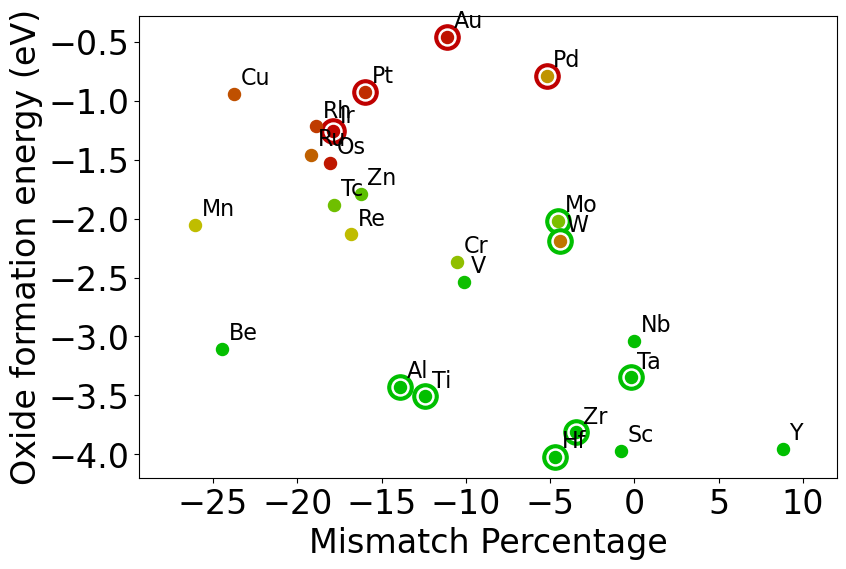

In [10]:
fs = 24
fs2 = 16

metals_exp_1 = metals[~np.isnan(data[:,0])]
metals_exp_1_ind_bool = np.isin(metals, metals_exp_1)

mi_exp = np.array([])
of_exp = np.array([])
decision_exp = np.array([])
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    mi_exp = np.append(mi_exp, mi[ind])
    of_exp = np.append(of_exp, of[ind])
    decision_exp = np.append(decision_exp, data[ind,0])

X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
lr = sklearn.linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X,Y)
preds = lr.predict_proba(np.vstack((mi,of)).T)
probs = preds[:,1]

colors_pred = np.array([mpl.colors.to_hex(c) for c in custom_cmap(probs)])

colors_exp_1 = colors_pred.copy()
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    colors_exp_1[ind] = colors_exp[ind]

fig, ax = plt.subplots(figsize=(9, 6))

# for i, met in enumerate(metals):
#     if data[i,0] == 0:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i])
#     elif data[i,0] == 1:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i])

for i, met in enumerate(metals):
    # ax.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
    # ax.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
    # ax.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)
    if metals_exp_1_ind_bool[i]:
        ax.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_exp[i], marker='o', s=330)
        ax.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=mpl.colors.to_hex((1,1,1)), marker='o', s=150)
    ax.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=colors_pred[i], marker='o', s=75)

for i, txt in enumerate(df['Symbol']):
    if txt in metals:
            plt.annotate(txt, (df['Mismatch'].iloc[i]+0.4, df['oxide_formation_energy'].iloc[i]+0.08), fontsize=fs2)


# for met in df['Symbol']:
#     if met not in metals:
#         plt.scatter(df[df['Symbol']==met]['Mismatch'], df[df['Symbol']==met]['oxide_formation_energy'], color=mpl.colors.to_hex((0,0,0)))
# #plot energy vs oxide formation energy

# # plt.scatter(df['Mismatch'], df['oxide_formation_energy'])

# for i, txt in enumerate(df['Symbol']):
#     if txt not in metals:
#         plt.annotate(txt, (df['Mismatch'].iloc[i], df['oxide_formation_energy'].iloc[i]))

plt.xlim(right=12)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlabel('Mismatch Percentage', fontsize=fs)
plt.ylabel('Oxide formation energy (eV)', fontsize=fs)
plt.show()